In [26]:
import nltk
nltk.download('punkt')

import re
import pandas as pd

import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier

import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [28]:
import pandas as pd
df_reviews = pd.read_pickle("udemy_reviews.pkl")
# Aplica pos/neg
df_reviews['tag']=df_reviews['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
df_reviews = df_reviews[df_reviews['comment'].str.contains("\s")]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_reviews = df_reviews[df_reviews['comment'].str.len() >= 12]
#df_reviews = df_reviews.sample(10000)
df_reviews.sample(5)

,id,course,rating,comment,user,tag
44613,78158126,2516170,4.5,Sigo a nicolas desde sus videos en youtube y explica excelente,Nestor Alfonso Cardenas Guerra,pos
77828,37208390,2257278,5.0,excelente,Cesar cordoba,pos
37868,68925094,1148270,3.5,"Si. Aunque a veces es lenta la explicación, pero igual me gusta todo los detalles que da.",Johanna Amézquita,neg
34818,6475930,900338,5.0,"Ha sido muy claro con respecto a los controles del software, en mi caso son datos que conocí por intuición ya que este programa comencé a usarlo sin ayuda de nadie, pero la forma de aprenderlo con un maestro refuerza lo que se y encuentro mayor sentido a las herramientas que uso a diario.",Oscar Alberto Ramirez Kramer,pos
34731,65869166,1453938,5.0,"Excelente curso, explicado de forma simple y detallada. muchas gracias al instructor.",Rafael Márquez Castro,pos


In [29]:
df = df_reviews[['comment','tag']].rename(columns={'comment': 'review'})
df.head(5)

,review,tag
6545,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,neg
6546,Los conocimientos son claros y concisos para lo requerido,pos
6547,hermoso,pos
6548,Excelente !!!,pos
6733,Excelente todo!,pos


In [ ]:
df['tag'].value_counts()

pos    150892
neg     23249
Name: tag, dtype: int64

In [5]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = []

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out


In [6]:
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
# separamos entre train y test sets
X = df.review
y = df.tag
X_train_text, X_test_text, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.20, random_state=1234)

# Limpieza del texto
def clean_text(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp]# and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    return word

def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras

In [7]:
clean_text('hola soy un gérmen y tendría pulgas. Pero no,creo que no. O si. excelente! excelente')


'hola germen tendria pulgas creo si excelente excelente'

In [8]:
len(X_train_text),len(X_test_text)

(8000, 2000)

# Naive Bayes con GridSearch y PreProcesamiento

In [9]:
# Defino el pipeline
pipeline_NB = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', MultinomialNB())])

parameters_NB = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [0.05, 0.1],
              'clf__alpha': [0.01,0.1]}

# Fit and tune model
clf_pipe_feature_sel_NB = GridSearchCV(pipeline_NB, parameters_NB,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_NB.fit(X_train_text, y_train);

In [10]:
best_pipeline_feature_sel_NB = clf_pipe_feature_sel_NB.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_NB.best_score_)
print("\nBest parameters set:")
best_parameters_NB = best_pipeline_feature_sel_NB.get_params()
print("tfidf__ngram_range:",best_parameters_NB["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_NB["tfidf__min_df"])
print("clf__alpha:",best_parameters_NB["clf__alpha"])

Best Cross-Validation: 0.4622571609288878

Best parameters set:
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: 0.01


# Regresión Logística


---




In [11]:
pipeline_log = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', LogisticRegression(random_state=0, multi_class='ovr'))])

parameters_log = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [.05],
              'clf__penalty': ['l1','l2']}

# Fit and tune model
clf_pipe_feature_sel_log = GridSearchCV(pipeline_log, parameters_log,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_log.fit(X_train_text, y_train);


C:\Users\Faolin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.46225716]
  warnings.warn(
C:\Users\Faolin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [       nan 0.46225717]
  warnings.warn(


In [12]:
best_pipeline_feature_sel_log = clf_pipe_feature_sel_log.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_log.best_score_)
print("\nBest parameters set:")
best_parameters_log = best_pipeline_feature_sel_log.get_params()
print("tfidf__ngram_range:",best_parameters_log["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_log["tfidf__min_df"])
print("clf__alpha:",best_parameters_log["clf__penalty"])

Best Cross-Validation: 0.4622571609288878

Best parameters set:
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: l2


# Feature Importance


In [13]:
pipeline_FI = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, 
                                               tokenizer=tokenizer, 
                                               stop_words="english", 
                                               ngram_range = (1,1),
                                               min_df      = best_parameters_log["tfidf__min_df"])),
                     ('clf', LogisticRegression(random_state=0, 
                                                multi_class='ovr',
                                                solver = 'lbfgs',
                                                penalty = best_parameters_log["clf__penalty"]))])

m = pipeline_FI.fit(X_train_text, y_train)

features = m[0].vocabulary_
weights  = m[1].coef_[0]


## Palabras importantes para clasificar reviews Postitivos

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

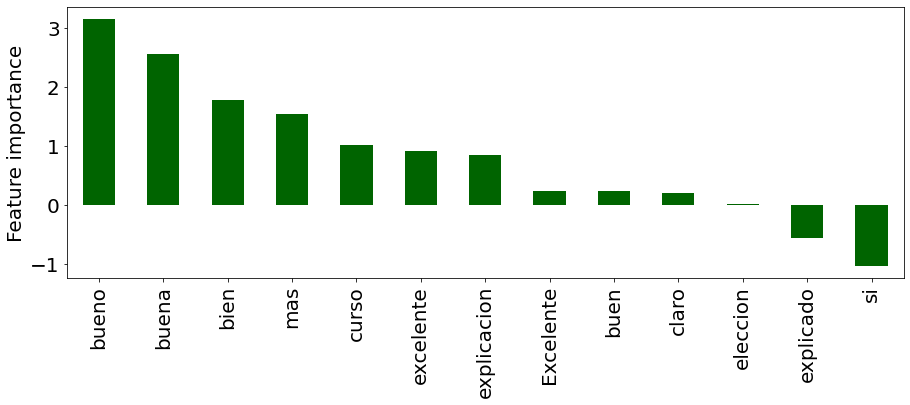

In [14]:
important_Poswords = pd.Series(weights,index=features).sort_values(ascending=False)[:25]
important_Poswords.plot(kind="bar",figsize=(15,5),color="darkgreen")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)

## Palabras importantes para clasificar reviews Negativos

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

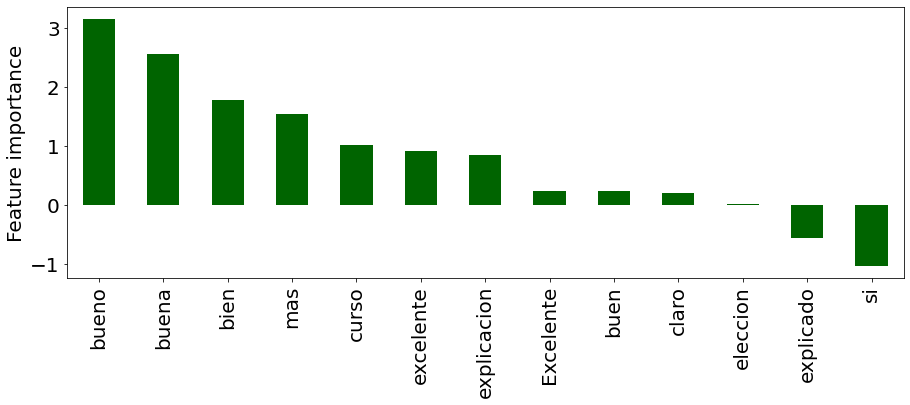

In [15]:
important_Negwords = pd.Series(weights,index=features).sort_values(ascending=False)[-25:]
important_Negwords.plot(kind="bar",figsize=(15,5),color="darkgreen")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)

In [16]:
pipeline_NN = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', MLPClassifier())])
parameters_NN = {'tfidf__ngram_range': [(1,2)],
              'tfidf__min_df': [.05],
              'clf__alpha':[1],
              'clf__learning_rate_init': [0.001,0.0001],
              'clf__hidden_layer_sizes': [(100),(1000),(10,10)]}

# Fit and tune model
clf_pipe_feature_sel_NN = GridSearchCV(pipeline_NN, parameters_NN,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_NN.fit(X_train_text, y_train);


In [17]:
best_pipeline_feature_sel_NN = clf_pipe_feature_sel_NN.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_NN.best_score_)
best_parameters_NN = best_pipeline_feature_sel_NN.get_params()
print("tfidf__ngram_range:",best_parameters_NN["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_NN["tfidf__min_df"])
print("clf__alpha:",best_parameters_NN["clf__alpha"])
print("clf__learning_rate_init:",best_parameters_NN["clf__learning_rate_init"])
print("clf__hidden_layer_sizes:",best_parameters_NN["clf__hidden_layer_sizes"])



Best Cross-Validation: 0.4622571609288878
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: 1
clf__learning_rate_init: 0.001
clf__hidden_layer_sizes: 100


# Performance en el TestSet

> Indented block



In [18]:
best_pipeline_feature_sel_NN = clf_pipe_feature_sel_NN.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_NN.best_score_)
best_parameters_NN = best_pipeline_feature_sel_NN.get_params()
print("tfidf__ngram_range:",best_parameters_NN["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_NN["tfidf__min_df"])
print("clf__alpha:",best_parameters_NN["clf__alpha"])
print("clf__learning_rate_init:",best_parameters_NN["clf__learning_rate_init"])
print("clf__hidden_layer_sizes:",best_parameters_NN["clf__hidden_layer_sizes"])



Best Cross-Validation: 0.4622571609288878
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: 1
clf__learning_rate_init: 0.001
clf__hidden_layer_sizes: 100


# TF-IDF
### ejemplo

In [19]:
vectorizer = TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer)

In [20]:
train_text = ["mono mono cabra",
              "mono mono elefante",
              "mono mono",
              "mono mono mono mono",
              "mono",
              "mono",
              "elefante"]

In [21]:
tfidf = vectorizer.fit_transform(train_text)

In [22]:
print(vectorizer.get_feature_names())

['cabra', 'elefante', 'mono']


In [23]:
tfidf.toarray()

array([[0.72498682, 0.        , 0.68876274],
       [0.        , 0.65796814, 0.75304577],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ]])

In [24]:
vectorizer.idf_

array([2.38629436, 1.98082925, 1.13353139])

In [25]:
vectorizer.transform(["mono cabra",
                      "mono cabra elefante",
                      "perro mono"]).toarray()

array([[0.90327141, 0.        , 0.42906965],
       [0.72268898, 0.59989392, 0.34328986],
       [0.        , 0.        , 1.        ]])